# Time Series Similarity

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import string

### 1. Data pre-process

In [6]:
df = pd.read_csv("dtw_test.csv")
df.head()

,id,series_a,series_b
0,0,"[75.125, 75.32, 75.06, 74.88, 74.92, 74.83, 75...","[75.125, 75.32, 74.88, 74.92, 74.83, 75.0, 74...."
1,1,"[26.0, 25.995, 25.8307, 25.85, 26.0, 26.0, 26....","[26.0, 25.8307, 26.0, 26.0, 26.0, 26.1471, 26...."
2,2,"[60.23, 60.1, 59.8589, 60.01, 60.19, 60.08, 60...","[59.8589, 60.19, 60.4, 60.59, 60.27, 60.23, 60..."
3,3,"[28.4, 28.65, 28.75, 28.65, 28.7099, 28.8, 28....","[28.4, 28.65, 28.7099, 29.0, 29.0651, 28.8, 28..."
4,4,"[4.98, 4.95, 4.88, 4.91, 4.93, 4.9, 4.9, 4.9, ...","[4.91, 4.93, 4.9, 4.9, 4.9132, 4.9344, 4.9155,..."


Each row contain two time series in the form of strings. These strings needs to be broken down in numbers, converted to floats and stored into an numpy array.

In [7]:
def convert_string2numbers(string):
    # remove characters from string , ] and [
    characters_to_remove = ",]["
    string = string.translate(str.maketrans('','', characters_to_remove))

    # convert each word to a float number and store it into an array
    numbers = []
    for word in string.split():
        numbers.append(float(word))
    return np.array(numbers)

### 2. Dynamic Time Wraping: toy model
In order to verify that the algorithm works fine we tested to two heavily down-sampled timeseries of the dataset.  

Text(0.5, 1.0, 'DTW-toy model: two offseted timeseries')

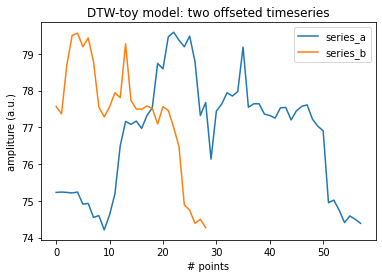

In [8]:
# choose timeseries from the dataset with id=0
row_number = 0
# convert data to floats
a = convert_string2numbers(df.iloc[row_number].series_a) 
b = convert_string2numbers(df.iloc[row_number].series_b)   
# downsample
a = a[400::10]
b = b[400::10]
# plot the time series
plt.figure(1)
plt.plot(a, label="series_a")
plt.plot(b, label="series_b")
plt.xlabel("# points")
plt.ylabel("ampliture (a.u.)")
plt.legend()
plt.title("DTW-toy model: two offseted timeseries")

#### Calculate Euclidean distances of each point and construct the Distance Matrix

In [12]:
def eucl_distance_calc(a, b):
    """
    This method simply calculated the one-dimensional euclidean distance
    between two points. 
    
    :a: the first vector
    :b: the second vector
    :return: the euclidean distances between each point
    """
    eucl_distances = np.zeros((len(a), len(b)))
    for i in range(len(a)):
        for j in range(len(b)):
            eucl_distances[i,j] = abs((a[i]-b[j]))
    return eucl_distances

def plotting(data):
    """
    A simple plotting as an image to represent the two time series 
    as a two-dimensional matrix and graphically illustrates either the distances
    between each point of the two vector-timeseries of the accumulated cost of each square motion.
    
    :data: the 2d data to pllot
    """
    im = plt.imshow(data) 
    plt.gca().invert_yaxis()
    plt.xlabel("series_a")
    plt.ylabel("series_b")
    plt.title("Euclidean Distance matrix")
    plt.colorbar();

def accumulated_cost_calc(a, b, dist):
    """
    Calculate the accumulate cost of each square of the matrix, special
    care must be taken on the edges of the matrix where the accumulated
    costs are separely calculated.
    :a: the first vector
    :b: the second vector
    :dist: the distance matrix
    :return: the accumulated cost matrix
    """
    accumulated_cost = np.zeros((len(a), len(b)))
    
    accumulated_cost[0,0] = dist[0,0]
    
    for i in range(1, len(a)):
        accumulated_cost[i,0] = dist[i,0] + accumulated_cost[i-1, 0]
    
    for j in range(1, len(b)):
        accumulated_cost[0,j] = dist[0,j] + accumulated_cost[0,j-1]  
        
    for i in range(1, len(a)):
        for j in range(1, len(b)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], 
                                         accumulated_cost[i-1, j], 
                                         accumulated_cost[i, j-1]) + dist[i, j]
    return accumulated_cost 

def path_cost_calc(a, b, accumulated_cost, dist):
    """
    This function uses as the accumulated cost and distances matrices and returns
    the optimal cost and path.    
    :a: the first vector
    :b: the second vector
    :accumulated_cost: the accumulated cost matrix
    :dist: the distance matrix
    :return: path, cost
    """
    path = [[len(a)-1, len(b)-1]]
    cost = 0
    i = len(a) - 1
    j = len(b) - 1
    while i>0 and j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], 
                                               accumulated_cost[i-1, j], 
                                               accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], 
                                                 accumulated_cost[i-1, j], 
                                                 accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j= j - 1
        path.append([i, j])
        
    path.append([0,0])
    for [a, b] in path:
        cost = cost + dist[a, b]
        
    return path, cost   

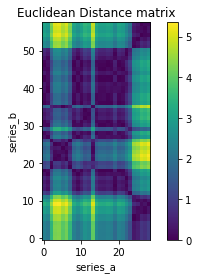

In [10]:
eucl_distances = eucl_distance_calc(a, b)
plotting(eucl_distances)

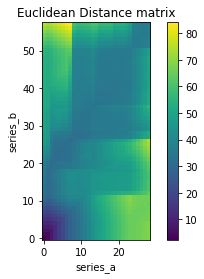

In [13]:
accumulated_cost = accumulated_cost_calc(a, b, eucl_distances)
plotting(accumulated_cost)

In [14]:
path, cost = path_cost = path_cost_calc(a, b, accumulated_cost, eucl_distances)
#print(path)
print(cost)

38.729999999999876


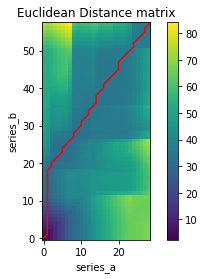

In [15]:
path_x = [point[0] for point in path]
path_y = [point[1] for point in path]
plotting(accumulated_cost)
plt.plot(path_y, path_x, 'r');

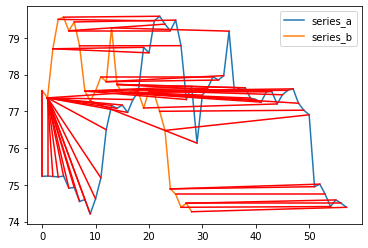

In [16]:
plt.plot(a, label='series_a')
plt.plot(b, label = 'series_b')
plt.legend();
paths = path_cost_calc(a, b, accumulated_cost, eucl_distances)[0]
for [map_a, map_b] in paths:
    #print (map_a, a[map_a], ":", map_b, b[map_b])
    plt.plot([map_a, map_b], [a[map_a], b[map_b]], 'r')

### 3. Dynamic Time Warping: application on real data

In [ ]:
# loop over all dataset rows
# and calculate cost distance for each pair
cost_id = []
for index, row in df.iterrows():
    a = convert_string2numbers(row.series_a)
    b = convert_string2numbers(row.series_b)
    
    eucl_distances = eucl_distance_calc(a, b)
    accumulated_cost = accumulated_cost_calc(a, b, eucl_distances)
    _, cost = path_cost_calc(a, b, accumulated_cost, eucl_distances)
    cost_id.append(cost)



In [ ]:
# print results to csv file
output = pd.DataFrame()
output['id'] = df.id
output['distance'] = cost_id
output.to_csv("requirement3.csv", index=False, sep=',')
